In [1]:
from time import time
from enum import Enum
import numpy as np
import matplotlib.pyplot as plt
import gymnasium as gym
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Categorical
from tqdm.notebook import tqdm
import os
import pandas as pd

In [2]:
class Actions(Enum):
    Buy_NTD = 0
    Buy_AUD = 1
    Buy_CAD = 2
    Buy_EUR = 3
    Buy_GBP = 4
    Buy_HKD = 5
    Buy_JPY = 6
    Buy_SGD = 7
    Buy_USD = 8

class Positions(Enum):
    # 代表持有幣別
    NTD = 0
    AUD = 1
    CAD = 2
    EUR = 3
    GBP = 4
    HKD = 5
    JPY = 6
    SGD = 7
    USD = 8

    def opposite(self,action):
      return Positions(action)

In [3]:
class TradingEnv(gym.Env):

    metadata = {'render_modes': ['human'], 'render_fps': 3}

    def __init__(self, df, window_size, render_mode=None):
        assert df.ndim == 2
        assert render_mode is None or render_mode in self.metadata['render_modes']
        self.global_previous_total_profit = 1  # 定義全局變數
        self.render_mode = render_mode
        self.df = df
        self.window_size = window_size
        self.prices, self.signal_features = self._process_data()
        self.shape = (window_size, self.signal_features.shape[1])

        # spaces
        self.action_space = gym.spaces.Discrete(len(Actions))
        INF = 1e10
        self.observation_space = gym.spaces.Box(
            low=-INF, high=INF, shape=self.shape, dtype=np.float32,
        )

        # episode
        self._start_tick = self.window_size
        self._end_tick = len(self.prices) - 1
        self._truncated = None
        self._current_tick = None
        self._last_trade_tick = None
        self._position = None
        self._position_history = None

        self._last_position = None
        self._action = None
        self._total_reward = None
        self._total_profit = None
        self._first_rendering = None
        self.history = None

    def reset(self, seed=None, options=None):
        super().reset(seed=seed, options=options)
        self.action_space.seed(int((self.np_random.uniform(0, seed if seed is not None else 1))))
        self._truncated = False
        self._current_tick = self._start_tick
        self._last_trade_tick = self._current_tick - 1
        self._position = Positions.NTD
        self._position_history = (self.window_size * [None]) + [self._position]
        self._action = 0
        self._total_reward = 0.
        self._total_profit = 1.  # unit
        self._first_rendering = True
        self.history = {}

        observation = self._get_observation()
        info = self._get_info()

        if self.render_mode == 'human':
            self._render_frame()

        return observation, info

    def step(self, action):
        self._action = action
        self._truncated = False
        self._current_tick += 1

        if self._current_tick == self._end_tick:
            self._truncated = True
        self._update_profit(action)
        step_reward = self._calculate_reward(action)
        self._total_reward += step_reward



        trade = False

        if action != self._position.value:
            trade = True

        if trade:
            self._last_position = self._position
            self._position = self._position.opposite(action)
            self._last_trade_tick = self._current_tick

        self._position_history.append(self._position)
        observation = self._get_observation()
        info = self._get_info()
        self._update_history(info)

        if self.render_mode == 'human':
            self._render_frame()

        return observation, step_reward, self._truncated, info

    def _get_info(self):
        return dict(
            total_reward=self._total_reward,
            total_profit=self._total_profit,
            position=self._position
        )

    def _get_observation(self):
        return self.signal_features[self._current_tick-self.window_size:self._current_tick]

    def _update_history(self, info):
        if not self.history:
            self.history = {key: [] for key in info.keys()}

        for key, value in info.items():
            self.history[key].append(value)

    def _render_frame(self):
        self.render()

    def choice_price_col(self,position, buy_or_sell="買入"):
        foreign_price = None
        if position == Positions.AUD:
          foreign_price = self.prices[f'AUD即期{buy_or_sell}'].to_numpy()
        elif position == Positions.CAD:
          foreign_price = self.prices[f'CAD即期{buy_or_sell}'].to_numpy()
        elif position == Positions.EUR:
          foreign_price = self.prices[f'EUR即期{buy_or_sell}'].to_numpy()
        elif position == Positions.GBP:
          foreign_price = self.prices[f'GBP即期{buy_or_sell}'].to_numpy()
        elif position == Positions.HKD:
          foreign_price = self.prices[f'HKD即期{buy_or_sell}'].to_numpy()
        elif position == Positions.JPY:
          foreign_price = self.prices[f'JPY即期{buy_or_sell}'].to_numpy()
        elif position == Positions.SGD:
          foreign_price = self.prices[f'SGD即期{buy_or_sell}'].to_numpy()
        elif position == Positions.USD:
          foreign_price = self.prices[f'USD即期{buy_or_sell}'].to_numpy()
        return foreign_price


    def render(self, mode='human'):

        def _plot_position():
            # 有買賣
            if self._action != self._position.value:

              # 現在不是持有台幣(即有買入外幣)
              if self._position != Positions.NTD:
                # 買入用紅色
                buy_price_col = self.choice_price_col(self._position)
                plt.scatter(self._current_tick, buy_price_col[self._current_tick], color='red')

              # 上一步不是持有台幣(即有賣出外幣)
              if self._last_position != Positions.NTD:
                # 賣出用綠色
                sell_price_col = self.choice_price_col(self._last_position)
                plt.scatter(self._current_tick, sell_price_col[self._current_tick], color='green')
        start_time = time()

        if self._first_rendering:
            self._first_rendering = False
            plt.cla()
            plt.plot(self.prices['AUD即期買入'].to_numpy(), label="AUD")
            plt.plot(self.prices['CAD即期買入'].to_numpy(), label="CAD")
            plt.plot(self.prices['EUR即期買入'].to_numpy(), label="EUR")
            plt.plot(self.prices['GBP即期買入'].to_numpy(), label="GBP")
            plt.plot(self.prices['HKD即期買入'].to_numpy(), label="HKD")
            plt.plot(self.prices['JPY即期買入'].to_numpy(), label="JPY")
            plt.plot(self.prices['SGD即期買入'].to_numpy(), label="SGD")
            plt.plot(self.prices['USD即期買入'].to_numpy(), label="USD")
            # plt.yscale('log')
            plt.legend(bbox_to_anchor=(1.0, 1.0))

            # 起始點標藍色
            plt.scatter(self._current_tick, self.prices['AUD即期買入'].to_numpy()[self._current_tick], color='blue')
            plt.scatter(self._current_tick, self.prices['CAD即期買入'].to_numpy()[self._current_tick], color='blue')
            plt.scatter(self._current_tick, self.prices['EUR即期買入'].to_numpy()[self._current_tick], color='blue')
            plt.scatter(self._current_tick, self.prices['GBP即期買入'].to_numpy()[self._current_tick], color='blue')
            plt.scatter(self._current_tick, self.prices['HKD即期買入'].to_numpy()[self._current_tick], color='blue')
            plt.scatter(self._current_tick, self.prices['JPY即期買入'].to_numpy()[self._current_tick], color='blue')
            plt.scatter(self._current_tick, self.prices['SGD即期買入'].to_numpy()[self._current_tick], color='blue')
            plt.scatter(self._current_tick, self.prices['USD即期買入'].to_numpy()[self._current_tick], color='blue')

        _plot_position()

        plt.suptitle(
            "Total Reward: %.6f" % self._total_reward + ' ~ ' +
            "Total Profit: %.6f" % self._total_profit
        )

        end_time = time()
        process_time = end_time - start_time

        pause_time = (1 / self.metadata['render_fps']) - process_time
        assert pause_time > 0., "High FPS! Try to reduce the 'render_fps' value."

        plt.pause(pause_time)


    def render_all(self, title=None):

        plt.cla()
        plt.plot(self.prices['AUD即期買入'].to_numpy(), label="AUD")
        plt.plot(self.prices['CAD即期買入'].to_numpy(), label="CAD")
        plt.plot(self.prices['EUR即期買入'].to_numpy(), label="EUR")
        plt.plot(self.prices['GBP即期買入'].to_numpy(), label="GBP")
        plt.plot(self.prices['HKD即期買入'].to_numpy(), label="HKD")
        plt.plot(self.prices['JPY即期買入'].to_numpy(), label="JPY")
        plt.plot(self.prices['SGD即期買入'].to_numpy(), label="SGD")
        plt.plot(self.prices['USD即期買入'].to_numpy(), label="USD")
        plt.legend(bbox_to_anchor=(1.0, 1.0))

        last_positions = Positions.NTD

        for i, position in enumerate(self._position_history):
          if position != None:
            # 有買賣
            if position != last_positions:
              # 現在不是持有台幣(即有買入外幣)
              if position != Positions.NTD:
                price_col = self.choice_price_col(position)
                plt.scatter(i, price_col[i], color='red')

              # 上一步不是持有台幣(即有賣出外幣)
              if last_positions != Positions.NTD:
                price_col = self.choice_price_col(last_positions)
                plt.scatter(i, price_col[i], color='green')

              last_positions = self._position_history[i]

        if title:
            plt.title(title)

        plt.suptitle(
            "Total Reward: %.6f" % self._total_reward + ' ~ ' +
            "Total Profit: %.6f" % self._total_profit
        )

    def close(self):
        plt.close()

    def save_rendering(self, filepath):
        plt.savefig(filepath)

    def pause_rendering(self):
        plt.show()

    def _process_data(self):
        raise NotImplementedError

    def _calculate_reward(self, action):
        raise NotImplementedError

    def _update_profit(self, action):
        raise NotImplementedError


In [4]:
class ForexEnv(TradingEnv):

    def __init__(self, df, window_size, frame_bound, render_mode=None):
        assert len(frame_bound) == 2

        self.frame_bound = frame_bound
        super().__init__(df, window_size, render_mode)

    def _process_data(self):
        raise NotImplementedError

    def _calculate_reward(self, action):
        raise NotImplementedError

    def _update_profit(self, action):

        # 有交易
        if action != self._position.value:
          # 原本非台幣
          if self._position != Positions.NTD:
            # 此處賣出為銀行方，等於投資者的買入
            buy_price_col = self.choice_price_col(self._position, "賣出")
            buy_price = buy_price_col[self._last_trade_tick]

            # 此處買入為銀行方，等於投資者的賣出
            sell_price_col = self.choice_price_col(self._position, "買入")
            sell_price = sell_price_col[self._current_tick]
            self._total_profit = (self._total_profit / buy_price) * sell_price

        # 結束
        if self._truncated:
          if action != Actions.Buy_NTD.value:
            buy_price_col = self.choice_price_col(Positions(action), "賣出")
            buy_price = buy_price_col[self._last_trade_tick]


            sell_price_col = self.choice_price_col(Positions(action), "買入")
            sell_price = sell_price_col[self._current_tick]

            self._total_profit = (self._total_profit / buy_price) * sell_price
    def get_total_profit(self):
      return self._total_profit


In [5]:
torch.manual_seed(1234)
np.random.seed(1234)

In [6]:
train_df = pd.read_csv('./train.csv')
# 處理空值
train_df.replace("-", 0, inplace=True)
train_df

,Date,AUD現鈔買入,AUD現鈔賣出,AUD即期買入,AUD即期賣出,CAD現鈔買入,CAD現鈔賣出,CAD即期買入,CAD即期賣出,EUR現鈔買入,...,JPY即期買入,JPY即期賣出,SGD現鈔買入,SGD現鈔賣出,SGD即期買入,SGD即期賣出,USD現鈔買入,USD現鈔賣出,USD即期買入,USD即期賣出
0,2006-01-02,23.74,24.49,24.00,24.20,27.85,28.67,28.17,28.37,38.09,...,0.2769,0.2809,19.17,20.06,19.67,19.85,32.470,33.005,32.770,32.870
1,2006-01-03,23.70,24.44,23.96,24.16,27.67,28.48,27.99,28.19,38.04,...,0.2766,0.2806,19.12,20.01,19.62,19.80,32.295,32.830,32.595,32.695
2,2006-01-04,23.63,24.37,23.89,24.09,27.56,28.37,27.88,28.08,38.18,...,0.2767,0.2807,19.04,19.92,19.54,19.72,31.985,32.520,32.285,32.385
3,2006-01-05,23.57,24.31,23.83,24.03,27.50,28.31,27.82,28.02,37.94,...,0.2744,0.2784,18.90,19.77,19.39,19.57,31.670,32.205,31.970,32.070
4,2006-01-06,23.65,24.39,23.91,24.11,27.25,28.05,27.56,27.76,38.14,...,0.2753,0.2793,18.97,19.85,19.47,19.65,31.830,32.372,32.130,32.230
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2847,2017-05-24,22.20,22.86,22.39,22.62,21.93,22.67,22.20,22.42,33.00,...,0.2674,0.2714,21.19,21.97,21.61,21.79,29.800,30.342,30.100,30.200
2848,2017-05-25,22.20,22.86,22.39,22.62,22.06,22.80,22.33,22.55,33.11,...,0.2669,0.2709,21.22,22.00,21.64,21.82,29.715,30.257,30.015,30.115
2849,2017-05-26,22.09,22.75,22.28,22.51,21.98,22.72,22.25,22.47,33.06,...,0.2686,0.2726,21.24,22.02,21.66,21.84,29.740,30.282,30.040,30.140
2850,2017-05-31,22.11,22.77,22.30,22.53,22.00,22.74,22.27,22.49,32.96,...,0.2693,0.2733,21.24,22.02,21.66,21.84,29.740,30.282,30.040,30.140


In [7]:
def my_calculate_reward(self, action):
    step_reward = 0
    if self._position == Positions.NTD:
        step_reward = 0

    else:
        price_col = self.choice_price_col(self._position)
        current_price = price_col[self._current_tick]
        last_day_price = price_col[self._current_tick-1]
        step_reward = (current_price - last_day_price) / last_day_price
    return step_reward
def my_process_data(env):
    start = env.frame_bound[0] - env.window_size
    end = env.frame_bound[1]
    prices = env.df.iloc[start:end, :].filter(like='即期')

    # 這邊可修改想要使用的 feature
    signal_features = env.df.iloc[:,1:].to_numpy()[start:end]
    return prices, signal_features

class MyForexEnv(ForexEnv):
    # 除 _process_data 和 _calculate_reward 外，其餘功能 (class function) 禁止覆寫
    _process_data = my_process_data
    _calculate_reward = my_calculate_reward

# window_size: 能夠看到幾天的資料當作輸入, frame_bound: 想要使用的資料日期區間
# 可修改 frame_bound 來學習不同的環境資料，frame_bound起始值必須>=window_size
# 不可修改此處 window_size 參數 ，最後計算分數時 window_size 也會設為10
env = MyForexEnv(df=train_df, window_size=10, frame_bound=(100, 1000))

env information:
> env.shape: (10, 32)
> df.shape: (2852, 33)
> prices.shape: (910, 16)
> signal_features.shape: (910, 32)


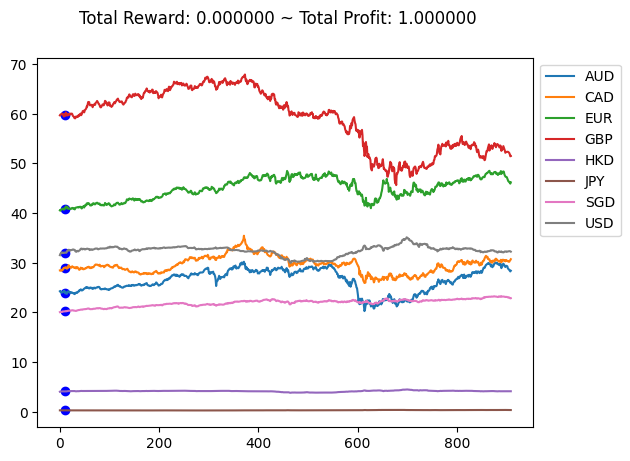

In [8]:
print("env information:")
print("> env.shape:", env.shape)
print("> df.shape:", env.df.shape)
print("> prices.shape:", env.prices.shape)
print("> signal_features.shape:", env.signal_features.shape)

env.reset()
env.render()

{'total_reward': 0.03350401683375162, 'total_profit': 0.001771118414994932, 'position': <Positions.CAD: 2>}


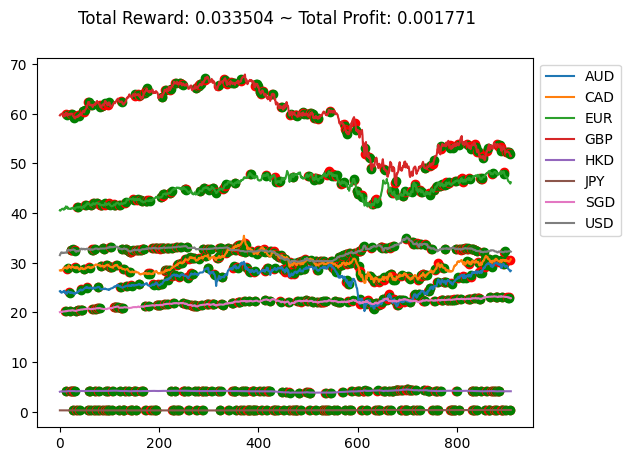

In [9]:
observation = env.reset()

while True:
    action = env.action_space.sample()
    observation, reward, done, info = env.step(action)
    if done:
        print(info)
        break

env.render_all()
plt.show()

In [10]:
class QNetwork(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, 32)
        self.fc2 = nn.Linear(32, 32)
        self.fc3 = nn.Linear(32, 9)  # Output_dim 是動作的數量

    def forward(self, state):
        hid = torch.tanh(self.fc1(state))
        hid = torch.tanh(self.fc2(hid))
        return self.fc3(hid)

In [11]:
class QLearningAgent():
    def __init__(self, q_network):
        self.q_network = q_network
        self.optimizer = torch.optim.SGD(q_network.parameters(), lr=0.01)
        self.q_values_history = []  # 新增一個屬性來保存 Q 值歷史
    def learn(self, state, action, reward, next_state, done):
        # 計算 Q-value 的目標值
        gamma=0.95
        q_value_target = reward + (1 - done) * gamma * torch.max(self.q_network(next_state))

        # 計算 Q-value 的預測值
        q_value_pred = self.q_network(state)[action]
        self.q_values_history.append(q_value_pred.item())
        # 計算均方誤差損失
        loss = F.mse_loss(q_value_pred, q_value_target)

        # 更新網路
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def choose_action(self, state, epsilon):
        # 以 epsilon-greedy 方式選擇動作
        if np.random.rand() < epsilon:
            return np.random.choice(env.action_space.n)
        else:
            # 根據 Q-value 選擇最佳動作
            with torch.no_grad():
                q_values = self.q_network(state)
            return torch.argmax(q_values).item()
    def save_ckpt(self, ckpt_path):
        torch.save({
            'model_state_dict': self.q_network.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'optimizer_param_groups': self.optimizer.param_groups,
        }, ckpt_path)

    def load_ckpt(self, ckpt_path):
        if os.path.exists(ckpt_path):
            checkpoint = torch.load(ckpt_path)
            self.q_network.load_state_dict(checkpoint['model_state_dict'])
            self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
            if 'optimizer_param_groups' in checkpoint:
                self.optimizer.param_groups = checkpoint['optimizer_param_groups']
        else:
            print("Checkpoint file not found, use default settings")

In [12]:
q_network = QNetwork(env.shape[0] * env.shape[1])
agent = QLearningAgent(q_network)

In [13]:
total_episodes = 800
epsilon_start = 1.0
epsilon_final = 0.1
epsilon_decay_steps = 400
history_total_rewards=[]
CHECKPOINT_PATH = './model.ckpt' # agent model 儲存位置
# 訓練循環
epsilon = epsilon_start
epsilon_decay = (epsilon_start - epsilon_final) / epsilon_decay_steps
agent.q_network.train()  # 訓練前，先確保 network 處在 training 模式

for episode in range(total_episodes):
     # 重置環境並獲取初始狀態
    
    state = torch.FloatTensor(env.reset()[0]).reshape(-1)
    total_reward = 0

    while True:
        action = agent.choose_action(state, epsilon)
        next_state, reward, done, _ = env.step(action)
        #return observation, step_reward, self._truncated, info
        # 將元組中的所有元素轉換為 NumPy 陣列，同樣檢查並轉換維度
        next_state_elements = [np.array(item) for item in next_state]
        for i in range(len(next_state_elements)):
            if next_state_elements[i].ndim == 0:
                next_state_elements[i] = np.array([next_state_elements[i]])

        next_state = torch.FloatTensor(np.concatenate(next_state_elements))
        agent.learn(state, action, reward, next_state, done)

        total_reward += reward
        state = next_state

        if done:
            break

    # 更新 epsilon
    epsilon = max(epsilon_final, epsilon - epsilon_decay)
    print(f"Episode {episode + 1}, Total Reward: {total_reward}")
agent.save_ckpt(CHECKPOINT_PATH)


Episode 1, Total Reward: -0.11295746371865217
Episode 2, Total Reward: -0.13703132209840824
Episode 3, Total Reward: -0.03525296645888265
Episode 4, Total Reward: 0.2901543801906991
Episode 5, Total Reward: -0.0853909386185465
Episode 6, Total Reward: -0.15781602045512733
Episode 7, Total Reward: 0.1463181592145951
Episode 8, Total Reward: 0.1723655597368271
Episode 9, Total Reward: 0.2865989959676364
Episode 10, Total Reward: 0.31964369702112244
Episode 11, Total Reward: -0.020685041331692605
Episode 12, Total Reward: 0.2252998700009329
Episode 13, Total Reward: -0.05339529997300087
Episode 14, Total Reward: 0.0058302991351052375
Episode 15, Total Reward: -0.013976757725572598
Episode 16, Total Reward: 0.19314727065104997
Episode 17, Total Reward: -0.02528600725038839
Episode 18, Total Reward: 0.17329916701462791
Episode 19, Total Reward: -0.12140545517536522
Episode 20, Total Reward: 0.14485719658217888
Episode 21, Total Reward: -0.1326345678891981
Episode 22, Total Reward: -0.085975

Episode 177, Total Reward: -0.1457289784015977
Episode 178, Total Reward: 0.11043781109382166
Episode 179, Total Reward: -0.15138011607647706
Episode 180, Total Reward: 0.0809677852279689
Episode 181, Total Reward: -0.1277294403355212
Episode 182, Total Reward: -0.042873262252473975
Episode 183, Total Reward: 0.13876889732144584
Episode 184, Total Reward: 0.17577997670739673
Episode 185, Total Reward: 0.1516017963141899
Episode 186, Total Reward: 0.13335762767131007
Episode 187, Total Reward: 0.25236080904549635
Episode 188, Total Reward: -0.00041898564426289713
Episode 189, Total Reward: 0.07769705607990392
Episode 190, Total Reward: 0.03425714375674688
Episode 191, Total Reward: 0.06822315678140066
Episode 192, Total Reward: -0.10390117301217418
Episode 193, Total Reward: -0.19923044297785336
Episode 194, Total Reward: 0.2132698400346136
Episode 195, Total Reward: 0.20213940742189915
Episode 196, Total Reward: 0.3203753718195036
Episode 197, Total Reward: -0.005032555913558487
Episod

Episode 351, Total Reward: 0.2770958757785058
Episode 352, Total Reward: -0.02836503365434052
Episode 353, Total Reward: 0.1579418653487108
Episode 354, Total Reward: 0.12174263650952714
Episode 355, Total Reward: 0.467252094910251
Episode 356, Total Reward: -0.032772366152481774
Episode 357, Total Reward: 0.18054578165504986
Episode 358, Total Reward: 0.15118811264560497
Episode 359, Total Reward: 0.2783437926340181
Episode 360, Total Reward: -0.0039404238819688645
Episode 361, Total Reward: -0.18717674496462713
Episode 362, Total Reward: 0.38147701111379395
Episode 363, Total Reward: 0.04426394150994198
Episode 364, Total Reward: 0.1026263984991201
Episode 365, Total Reward: 0.3250221272225069
Episode 366, Total Reward: 0.12366206714824787
Episode 367, Total Reward: 0.3636635818352256
Episode 368, Total Reward: 0.22496634210234
Episode 369, Total Reward: 0.00640692909661778
Episode 370, Total Reward: 0.06119811099028245
Episode 371, Total Reward: -0.03038599463719939
Episode 372, Tot

Episode 525, Total Reward: 0.23776558407876786
Episode 526, Total Reward: 0.19514191357098293
Episode 527, Total Reward: -0.09900640476016424
Episode 528, Total Reward: -0.17036512556745473
Episode 529, Total Reward: 0.2555044989432913
Episode 530, Total Reward: 0.22705100683318485
Episode 531, Total Reward: 0.0962756786681892
Episode 532, Total Reward: -0.28132955599792075
Episode 533, Total Reward: 0.04856535316363808
Episode 534, Total Reward: 0.1835147197562946
Episode 535, Total Reward: -0.018425902109194373
Episode 536, Total Reward: 0.16721677143804894
Episode 537, Total Reward: -0.01024665366786718
Episode 538, Total Reward: 0.033149564971700525
Episode 539, Total Reward: 0.21510012757051808
Episode 540, Total Reward: 0.06985744045985795
Episode 541, Total Reward: 0.3123242950720532
Episode 542, Total Reward: 0.09682030697989912
Episode 543, Total Reward: 0.1989414521585367
Episode 544, Total Reward: 0.22409467382183826
Episode 545, Total Reward: 0.07593828353135307
Episode 546

Episode 699, Total Reward: 0.12460657687085042
Episode 700, Total Reward: -0.03072332777408684
Episode 701, Total Reward: -0.19707604476828527
Episode 702, Total Reward: 0.0545438446216231
Episode 703, Total Reward: 0.07491424791631503
Episode 704, Total Reward: 0.08963089711783316
Episode 705, Total Reward: -0.04551906332924096
Episode 706, Total Reward: 0.23445052240841294
Episode 707, Total Reward: 0.1285145365960774
Episode 708, Total Reward: -0.1095943482511133
Episode 709, Total Reward: -0.006449401190656443
Episode 710, Total Reward: -0.060700489302434574
Episode 711, Total Reward: 0.1281183441385496
Episode 712, Total Reward: -0.041968989310390635
Episode 713, Total Reward: 0.2940374430552798
Episode 714, Total Reward: 0.0920722424317008
Episode 715, Total Reward: 0.23157322894361632
Episode 716, Total Reward: 0.18846582969769954
Episode 717, Total Reward: -0.10587901976511342
Episode 718, Total Reward: 0.2547981761323259
Episode 719, Total Reward: 0.24502073147245382
Episode 7

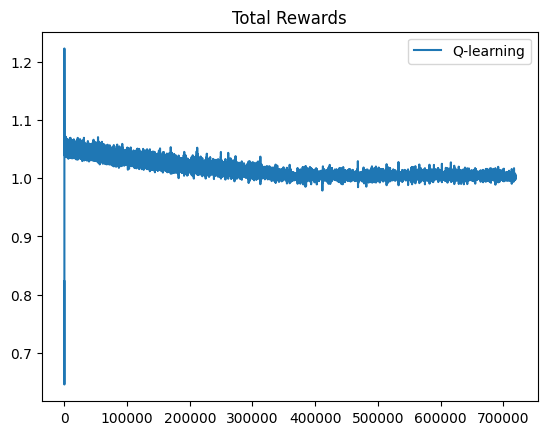

In [14]:
modified_list = [x + 1 for x in agent.q_values_history]
plt.plot(modified_list,label="Q-learning")

plt.legend()
plt.title("Total Rewards")
plt.show()

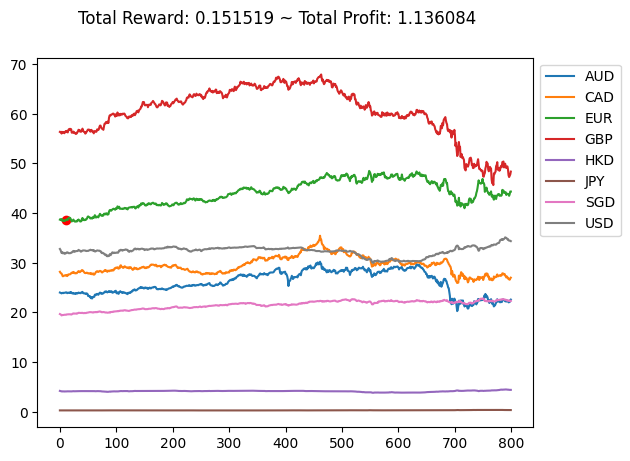

In [15]:
env = MyForexEnv(df=train_df, window_size=10, frame_bound=(10, 800))

network = QNetwork(env.shape[0] * env.shape[1])
test_agent = QLearningAgent(network)

checkpoint_path = './model.ckpt'

test_agent.load_ckpt(checkpoint_path)
test_agent.q_network.eval()  # 測試前先將 network 切換為 evaluation 模式

observation,_ = env.reset()
while True:
    state = torch.FloatTensor(observation).reshape(-1)  
    action = test_agent.choose_action(state, epsilon=0.0) 

    observation, reward, done, info = env.step(action)
    if done:
      break

env.render_all()
plt.show()

In [16]:
test_df = pd.read_csv('./test.csv')
test_df.replace("-", 0, inplace=True)
test_df

,Date,AUD現鈔買入,AUD現鈔賣出,AUD即期買入,AUD即期賣出,CAD現鈔買入,CAD現鈔賣出,CAD即期買入,CAD即期賣出,EUR現鈔買入,...,JPY即期買入,JPY即期賣出,SGD現鈔買入,SGD現鈔賣出,SGD即期買入,SGD即期賣出,USD現鈔買入,USD現鈔賣出,USD即期買入,USD即期賣出
0,2017-06-02,21.91,22.57,22.10,22.33,21.86,22.60,22.13,22.35,33.06,...,0.2678,0.2718,21.21,21.99,21.63,21.81,29.745,30.287,30.045,30.145
1,2017-06-03,22.08,22.74,22.27,22.50,21.93,22.67,22.20,22.42,33.24,...,0.2705,0.2745,21.28,22.06,21.70,21.88,29.735,30.277,30.035,30.135
2,2017-06-05,22.16,22.82,22.35,22.58,21.95,22.69,22.22,22.44,33.19,...,0.2702,0.2742,21.29,22.07,21.71,21.89,29.730,30.272,30.030,30.130
3,2017-06-06,22.20,22.86,22.39,22.62,21.99,22.73,22.26,22.48,33.15,...,0.2725,0.2765,21.28,22.06,21.70,21.88,29.735,30.277,30.035,30.135
4,2017-06-07,22.39,23.05,22.58,22.81,22.00,22.74,22.27,22.49,33.17,...,0.2732,0.2772,21.27,22.05,21.69,21.87,29.730,30.272,30.030,30.130
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
795,2020-08-07,20.90,21.68,21.17,21.40,21.61,22.52,22.00,22.22,34.09,...,0.2772,0.2812,20.94,21.85,21.43,21.61,29.090,29.760,29.440,29.540
796,2020-08-10,20.71,21.49,20.98,21.21,21.53,22.44,21.92,22.14,33.88,...,0.2762,0.2802,20.89,21.80,21.38,21.56,29.090,29.760,29.440,29.540
797,2020-08-11,20.77,21.55,21.04,21.27,21.65,22.56,22.04,22.26,33.85,...,0.2761,0.2801,20.91,21.82,21.40,21.58,29.100,29.770,29.450,29.550
798,2020-08-12,20.65,21.43,20.92,21.15,21.67,22.58,22.06,22.28,33.86,...,0.2744,0.2784,20.91,21.82,21.40,21.58,29.120,29.790,29.470,29.570


In [19]:
frame_bounds = [(10,100), (10,300), (10,800)]
mean_profit = 0

for frame_bound in frame_bounds:
  env = MyForexEnv(df=test_df, window_size=10, frame_bound=frame_bound)

  network = QNetwork(env.shape[0] * env.shape[1])
  test_agent = QLearningAgent(network)

  checkpoint_path = './model.ckpt'

  test_agent.load_ckpt(checkpoint_path)
  test_agent.q_network.eval()

  # 我們會跑10次取平均X
  for i in range(10):
    observation,_ = env.reset()
    while True:
        state = torch.FloatTensor(observation).reshape(-1) 
        action = test_agent.choose_action(state, epsilon=0.0) 

        observation, reward, done, info = env.step(action)
        if done:
          break

    # env.render_all()
    # plt.show()

    mean_profit += env.get_total_profit()

mean_profit /= (10 * len(frame_bounds))
print("Score:", mean_profit)

Score: 1.0288452136501423
